# Getting started
The script dependencies are:
* [ngsolve](https://ngsolve.org/downloads)
* [numpy](https://docs.scipy.org/doc/numpy/user/install.html)
* [scipy](https://scipy.org/install.html)
* [matplotlib](https://matplotlib.org/users/installing.html)
* the .vol file of the geometry _./team13_mesh.vol_

If the geometry file is erroneous, execute the python script $\texttt{./geometry.py}$, which generates the necessary $\texttt{.vol}$ file. 

    python3 geometry.py [-fullProblem True/False]


# Problem Description 
This script solves the T.E.A.M problem 13 (3-D Non-Linear Magnetostatic Model). The problem description can be found under the 
[link](https://www.compumag.org/wp/wp-content/uploads/2018/06/problem13.pdf).

The problem is based on the Maxwell equations with the corresponding boundary conditions 

$$
\begin{align}
    \nabla \times \textbf{H} &= \textbf{J}, \qquad &&\textbf{H}\times\textbf{n} = \textbf{0}\\
    \nabla \cdot \textbf{B} &= 0,  &&\textbf{B}\cdot\textbf{n} = 0
\end{align}
$$

for magnetostatic problems. The second equation allows the introduction of a magnetic vector potential $\textbf{A}$ as 

$$
     \begin{equation}
        \textbf{B} =  \nabla \times \textbf{A}.
    \end{equation}
$$


For the weak formulation 

$$
    \begin{equation}
        \int_\Omega \frac{1}{\mu(|\textbf{B}|)}\nabla\times \textbf{A}\cdot \nabla\times\textbf{v}\; d\Omega = \int_{\Omega_c} \textbf{J}\cdot \textbf{v}\;d\Omega 
    \end{equation}
$$

is used, which considers the non-linear material relationship 

$$
    \begin{equation}
        \textbf{H} =  \frac{1}{\mu(|\textbf{B}|)}\textbf{B}.
    \end{equation}
$$

Here, $\textbf{A}$ and $\textbf{v}$ are the trial and the test function, $\Omega$ is the domain of interest and $\Omega_c$ is the domain of the coil. 

For a unique solution, an additional regularisation term  with a small $\varepsilon > 0$ has been added:

$$
    \begin{equation}
        \int_\Omega \frac{1}{\mu(|\textbf{B}|)}\nabla\times \textbf{A}\cdot \nabla\times\textbf{v}\; d\Omega + \int_\Omega\varepsilon\;\textbf{A}\cdot\textbf{v}\;d\Omega= \int_{\Omega_c} \textbf{J}\cdot \textbf{v}\;d\Omega              
    \end{equation}
$$

The magnetic flux density of the solution is presented in Fig. 1.     



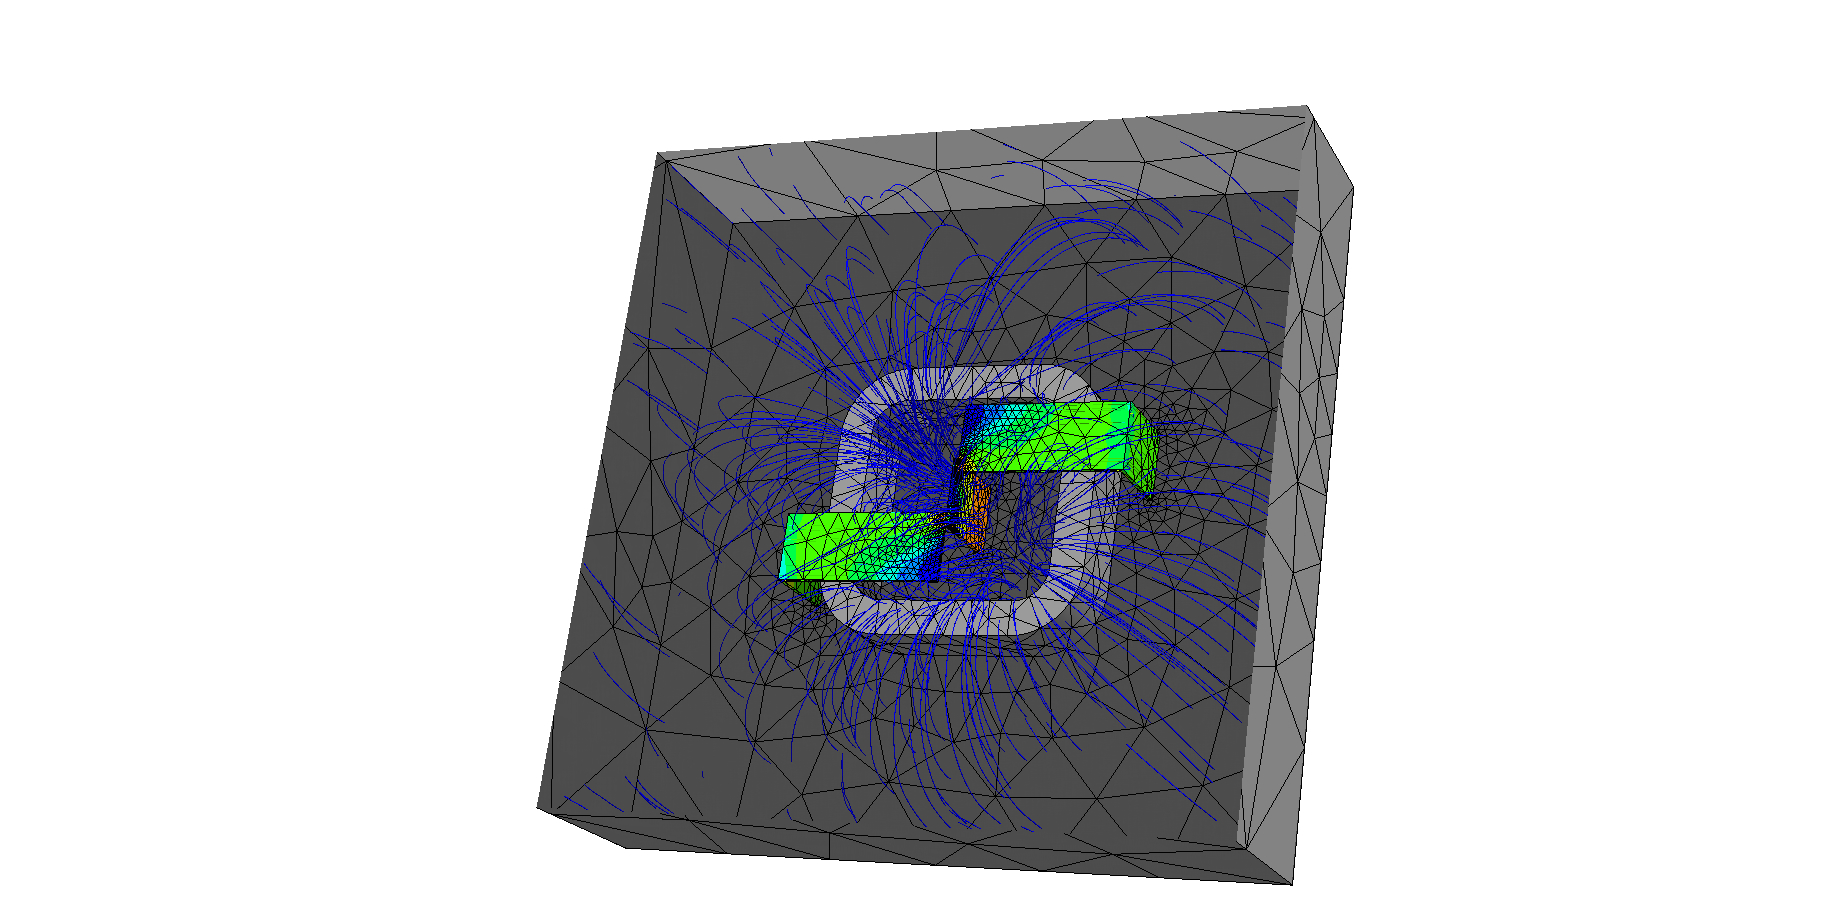
 <center><b>Fig. 1:</b> Illustration of the the magnetic flux density in the steel channels and magnetic field lines.</center> 

# Coding

## Imports
Importing the packages $\textit{ngsolve, netgen, numpy, ... }$ enables all functionalities of this script. Additionally, the number of used threads is reduced and the permeability of vacuum $\mu_0$ is set. 

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.csg import *
from ngsolve.internal import *

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
from geometry import generateGeometry, getMeshingParameters
%matplotlib widget
SetNumThreads(10)

mu0 = 4*np.pi*1e-7

## Setting Arguments
First of all, the simulation parameters need to be set. 
The space order defines the used order of the trial function and the test function within the finite element space. The variable $\texttt{I}_{ON}$ defines the value of Ampere-turns in the coil. Considering the [description](#Problem-Description), the value for the Ampere-turns is set to $ 1,000 $ or $ 3,000 $.

In [2]:
space_order = 2   
I0N = 1000                  # Ampere-turns 1000 or 3000

## Meshing
Next, the available mesh is loaded. The command $Curve(5)$ determines the roundness of the mesh and is obligatory for the provided geometry with its curved corners.

In [3]:
if True:
    geo = generateGeometry(maxh_iron = 100, fullProblem=False)
    mp = getMeshingParameters(maxh_global = 100)
    ngmesh = geo.GenerateMesh(mp=mp) # global maxh
    mesh = Mesh(ngmesh)
else:
    mesh = Mesh("./team13_mesh.vol")
    # mesh = Mesh("./team13_mesh_full.vol") # activate this to simulate the full problem
mesh.Curve(5)

# check domains
val = {"corner_right_back":1 , "corner_left_back":1, "corner_left_front":1, "corner_right_front":1, "brick_front":1, "brick_back":1, "brick_left":1, "brick_right":1, "iron":2, "air":1.5}
domains = mesh.MaterialCF(val, default=None)

In [28]:
help(Draw)

Draw(domains, mesh, "domains", draw_surf=False, 
     settings={"Clipping":{"enable":True, "z":-1, "dist":-1e-1}, "Objects":{"Clipping Plane":1}}, min = )

SyntaxError: invalid syntax (2401430871.py, line 4)

To check the correct assignment of the domains $\{air, iron, coil\}$, all corresponding subdomains are coloured accordingly. 

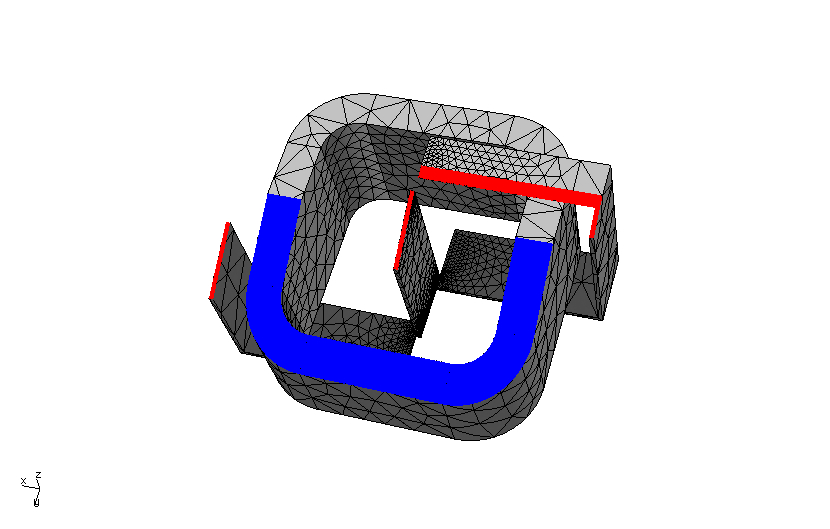
 <center><b>Fig. 2:</b> illustration of the geometry</center> 
 In Fig. 2 the coil is blue, the steel channels are red and the air is transperent. For a meaningful display a clipping plane was inserted.  

## Finite Element Space
The finite element space $H(curl, \Omega)$ is selected and homogeneous Dirichlet boundary conditions are prescribed on the far boundary. Additionally 
* the solution, i.e. magnetic vector potential $\textbf{A}$, is defined as $\texttt{sol}$,
* trial and test function are introduced,
* the $\textit{CoefficientFunction}$ $\texttt{B}$ for the magnetic flux density is determined and
* $\texttt{B}$ is drawn.

In [29]:
# create fe space
fes = HCurl(mesh, order=space_order, dirichlet="outer", nograds=True)

# magnetic vector potential as GridFunction
sol = GridFunction(fes, "A")
sol.vec[:] = 0

# Test- and Trialfunction
u = fes.TrialFunction()
v = fes.TestFunction()

# magnetic flux density
B = curl(sol)
Draw(B, mesh, "B", draw_surf=False)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

## Material Parameters

The non-linear magnetisation curve of the material is defined in the [description](#Problem-Description) .

In [30]:
H_KL = [ -4.47197834e-13, 1.60000000e+01, 3.00000000e+01, 5.40000000e+01\
    , 9.30000000e+01, 1.43000000e+02, 1.91000000e+02, 2.10000000e+02\
, 2.22000000e+02, 2.33000000e+02, 2.47000000e+02, 2.58000000e+02\
, 2.72000000e+02, 2.89000000e+02, 3.13000000e+02, 3.42000000e+02\
, 3.77000000e+02, 4.33000000e+02, 5.09000000e+02, 6.48000000e+02\
, 9.33000000e+02, 1.22800000e+03, 1.93400000e+03, 2.91300000e+03\
, 4.99300000e+03, 7.18900000e+03, 9.42300000e+03, 9.42300000e+03\
, 1.28203768e+04, 1.65447489e+04, 2.07163957e+04, 2.55500961e+04\
, 3.15206135e+04, 4.03204637e+04, 7.73038295e+04, 1.29272791e+05\
, 1.81241752e+05, 2.33210713e+05, 2.85179674e+05, 3.37148635e+05\
, 3.89117596e+05, 4.41086557e+05, 4.93055518e+05, 5.45024479e+05\
, 5.96993440e+05, 6.48962401e+05, 7.00931362e+05, 7.52900323e+05\
, 8.04869284e+05, 8.56838245e+05, 9.08807206e+05, 9.60776167e+05\
, 1.01274513e+06, 1.06471409e+06, 1.11668305e+06, 1.16865201e+06\
, 1.22062097e+06, 1.27258993e+06, 1.32455889e+06, 1.37652785e+06\
, 1.42849682e+06, 1.48046578e+06, 1.53243474e+06, 1.58440370e+06\
, 1.63637266e+06, 1.68834162e+06, 1.74031058e+06, 1.79227954e+06\
, 1.84424850e+06, 1.89621746e+06, 1.94818643e+06, 2.00015539e+06\
, 2.05212435e+06, 2.10409331e+06, 2.15606227e+06, 2.20803123e+06\
, 2.26000019e+06]

B_KL = [  0.00000000e+00, 2.50000000e-03, 5.00000000e-03, 1.25000000e-02\
, 2.50000000e-02, 5.00000000e-02, 1.00000000e-01, 2.00000000e-01\
, 3.00000000e-01, 4.00000000e-01, 5.00000000e-01, 6.00000000e-01\
, 7.00000000e-01, 8.00000000e-01, 9.00000000e-01, 1.00000000e+00\
, 1.10000000e+00, 1.20000000e+00, 1.30000000e+00, 1.40000000e+00\
, 1.50000000e+00, 1.55000000e+00, 1.60000000e+00, 1.65000000e+00\
, 1.70000000e+00, 1.75000000e+00, 1.80000000e+00, 1.80000000e+00\
, 1.86530612e+00, 1.93061224e+00, 1.99591837e+00, 2.06122449e+00\
, 2.12653061e+00, 2.19183673e+00, 2.25714286e+00, 2.32244898e+00\
, 2.38775510e+00, 2.45306122e+00, 2.51836735e+00, 2.58367347e+00\
, 2.64897959e+00, 2.71428571e+00, 2.77959184e+00, 2.84489796e+00\
, 2.91020408e+00, 2.97551020e+00, 3.04081633e+00, 3.10612245e+00\
, 3.17142857e+00, 3.23673469e+00, 3.30204082e+00, 3.36734694e+00\
, 3.43265306e+00, 3.49795918e+00, 3.56326531e+00, 3.62857143e+00\
, 3.69387755e+00, 3.75918367e+00, 3.82448980e+00, 3.88979592e+00\
, 3.95510204e+00, 4.02040816e+00, 4.08571429e+00, 4.15102041e+00\
, 4.21632653e+00, 4.28163265e+00, 4.34693878e+00, 4.41224490e+00\
, 4.47755102e+00, 4.54285714e+00, 4.60816327e+00, 4.67346939e+00\
, 4.73877551e+00, 4.80408163e+00, 4.86938776e+00, 4.93469388e+00\
, 5.00000000e+00]
bh_curve = BSpline (2, [0]+list(B_KL), list(H_KL)) # [0] + is needed!

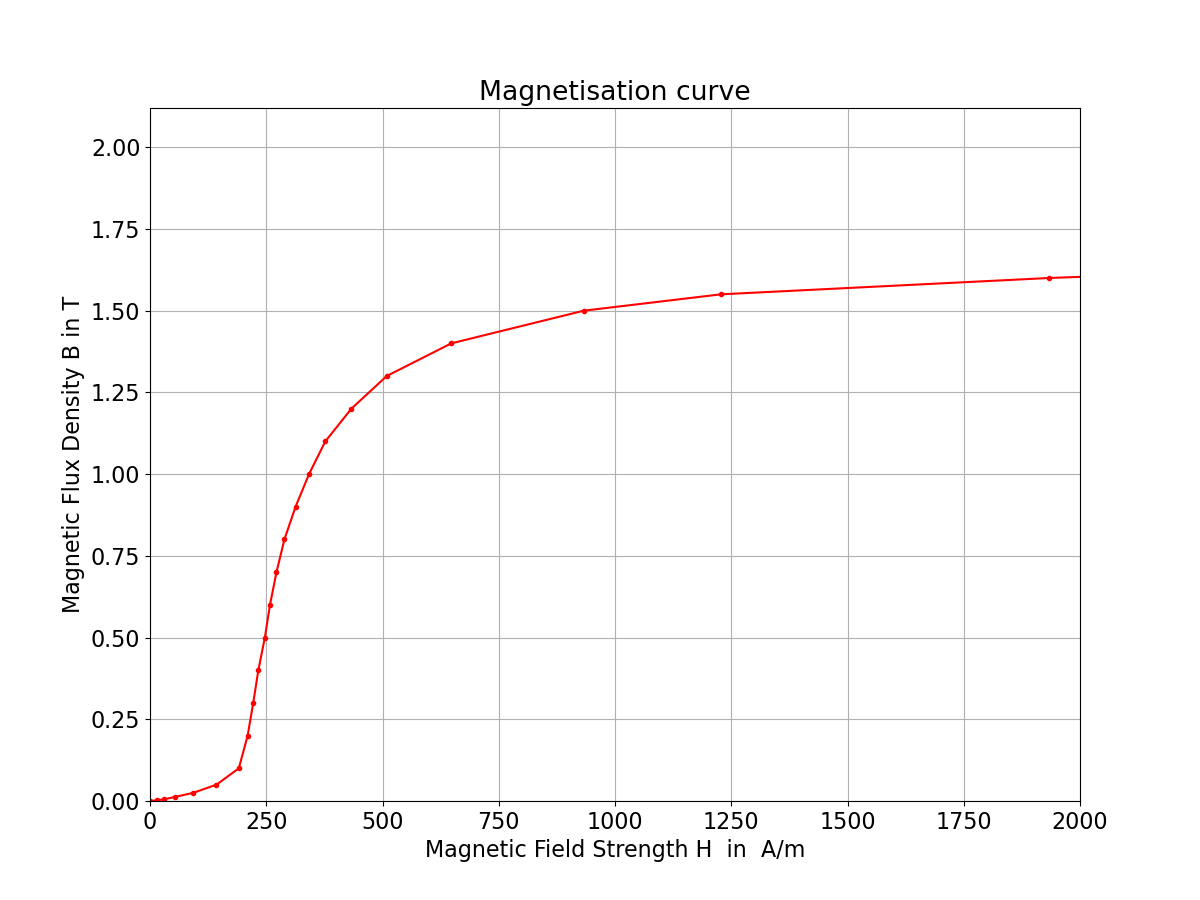

In [31]:
# create figure
plt.figure(1, figsize=[12, 9])
plt.clf()
plt.plot(H_KL, B_KL, '.-r')
plt.xlim(0, 2000)
plt.ylim(0, 2.12)
plt.grid()
plt.title("Magnetisation curve")
plt.xlabel("Magnetic Field Strength H  in  A/m")
plt.ylabel("Magnetic Flux Density B in T")
font = {'size'   : 16}
matplotlib.rc('font', **font)
plt.show(block=False)

The non-linear problem is solved by minimising the  the functional 

$$
\begin{equation}
 F(\textbf{A}) = \int_{\Omega}w(|\nabla\times \textbf{A}|)\;d\Omega - \int_{\Omega_c}\textbf{J}\cdot \textbf{A}\;d\Omega.
\end{equation}
$$

Therefore the magnetic energy density

$$
\begin{equation}
    w(B) = \int_0^B H(B')\;dB' 
\end{equation}
$$

has to be set  

In [32]:
energy_dens = bh_curve.Integrate()    # to be minimised

## Stiffness Matrix and Dirichlet Boundaries
The stiffness matrix is set on all regions and the regularisation term mentioned in the section  [description](#Problem-Description) is added.

In [33]:
a = BilinearForm(fes, symmetric=True)

a += SymbolicBFI(1/mu0 * curl(u)*curl(v), definedon=~mesh.Materials("iron"))
a += SymbolicEnergy(energy_dens(sqrt(1e-12+curl(u)*curl(u))), definedon=mesh.Materials("iron")) # 1e-12 ... to avoid 0
a += SymbolicBFI(1e-1*u*v)  # regularisation

# preconditioner
c = Preconditioner(a, type="direct", inverse="sparsecholesky")

The boundary condition 

$$
\begin{equation}
    \textbf{B}\cdot\textbf{n} = 0
\end{equation}
$$

is prescribed with the magnetic vector potential by

$$
\begin{align}
    \nabla\times\textbf{A} \cdot\textbf{n} &= 0\\
    \textbf{A} &= \textbf{0}\qquad\text{on }\Gamma_{outer}.
\end{align}
$$


## Biot-Savart Field and Neumann Boundaries

In this section, the impressed current density in the coil is modelled. This  has to be done carefully, since the orientation of the current has to be defined in the curved corners consistently. 

Without details:

In [34]:
A = 2500*1e-6       
J0 = I0N/A
# +++ bricks +++
J_brick_back = [1, 0]
J_brick_front = [-1, 0]
J_brick_left = [0, 1]
J_brick_right = [0, -1]

# +++ corners +++
# right back
x_right_back = x - 0.050
y_right_back = y - 0.050
r_right_back = (x_right_back**2 + y_right_back**2)**(1/2)
J_corner_right_back = [1/r_right_back * y_right_back, -1/r_right_back * x_right_back]

# left back
x_left_back = x + 0.050
y_left_back = y - 0.050
r_left_back = (x_left_back**2 + y_left_back**2)**(1/2)
J_corner_left_back =  [1/r_left_back * y_left_back, -1/r_left_back * x_left_back]


# left front
x_left_front = x + 0.050
y_left_front = y + 0.050
r_left_front = (x_left_front**2 + y_left_front**2)**(1/2)
J_corner_left_front = [1/r_left_front * y_left_front, -1/r_left_front * x_left_front]

# right front
x_right_front = x - 0.050
y_right_front = y + 0.050
r_right_front = (x_right_front**2 + y_right_front**2)**(1/2)
J_corner_right_front = [1/r_right_front * y_right_front, -1/r_right_front * x_right_front]

# J
val={   "corner_right_back":J_corner_right_back, "corner_left_back":J_corner_left_back, \
        "corner_left_front":J_corner_left_front, "corner_right_front":J_corner_right_front,\
        "brick_back":J_brick_back, "brick_left":J_brick_left, \
        "brick_front":J_brick_front, "brick_right":J_brick_right}    

J = J0 * CoefficientFunction([val[mat][0] if mat in val.keys() else 0 for mat in mesh.GetMaterials()])*CoefficientFunction((1,0,0)) + \
    J0 * CoefficientFunction([val[mat][1] if mat in val.keys() else 0 for mat in mesh.GetMaterials()])*CoefficientFunction((0,1,0))

Draw(J, mesh, "J")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

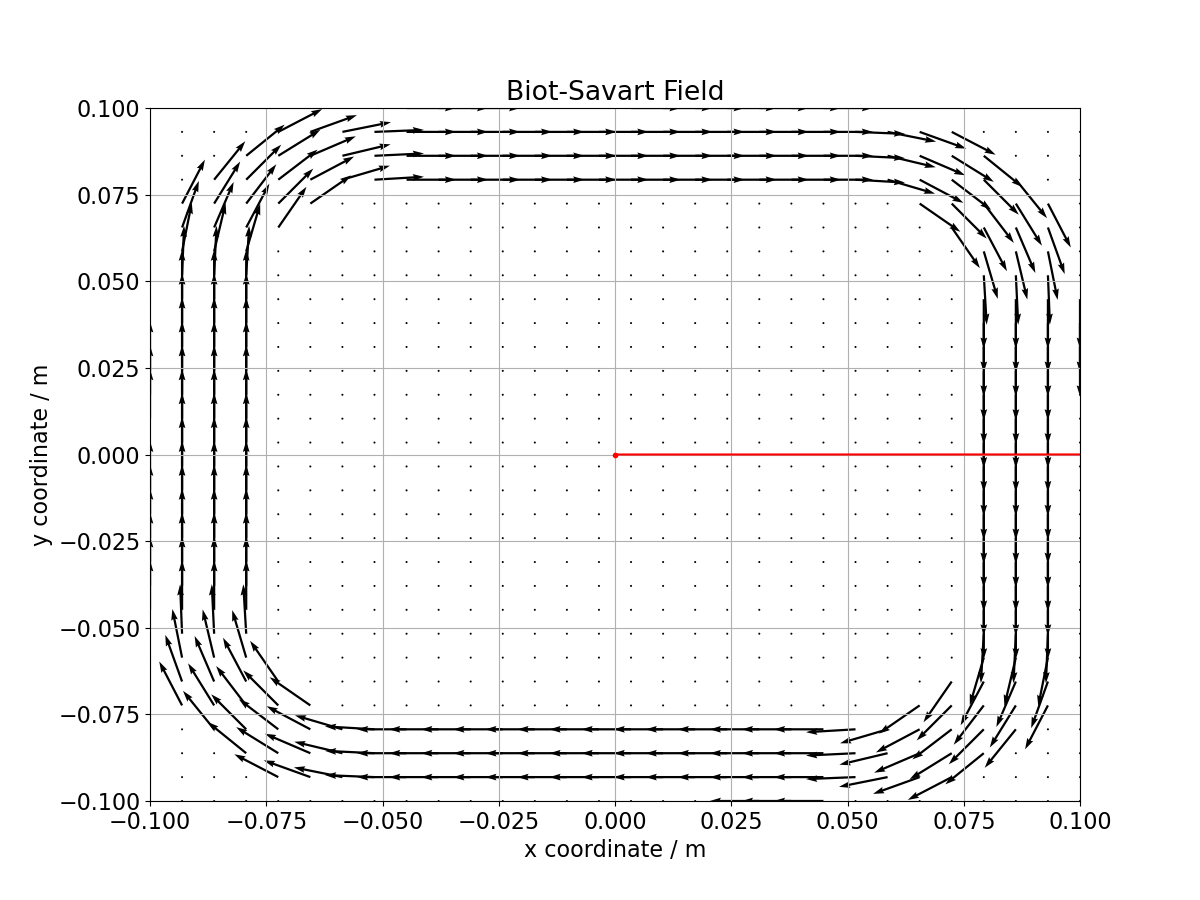

In [35]:
# figure
Nx = 30
Ny = 30
xi = np.linspace(-0.100, 0.100, Nx)
yi = np.linspace(-0.100, 0.100, Ny)

X, Y= np.meshgrid(xi, yi)
J_T = np.zeros([Nx, Ny, 2])

for i in range(Nx):
    for j in range(Ny):
        tmp = J(mesh(xi[i], yi[j], 0))
        J_T[i, j, 0] = tmp[0]
        J_T[i, j, 1] = tmp[1]
J_T[:, :, 0] = np.transpose(J_T[:, :, 0])
J_T[:, :, 1] = np.transpose(J_T[:, :, 1])
plt.figure(1, figsize=[10, 10])
plt.quiver(X, Y, J_T[:, :, 0], J_T[:, :, 1])
plt.xlabel("x coordinate / m")
plt.ylabel("y coordinate / m")
plt.title("Biot-Savart Field")
plt.xlim([-0.1, 0.1])
plt.ylim([-0.1, 0.1])
font = {'size'   : 16}
matplotlib.rc('font', **font)
plt.show(block=False)



The absolute value of the current density $|\textbf{J}|$ is constant in the whole volume of the coil. The $\textit{CoefficientFunction}$ $\texttt{J}$ is used for the right-hand side of the weak formulation. 

In [36]:
f = LinearForm(fes)
f += SymbolicLFI(J*v)

## Solving the Problem 

The problem is iteratively solved by finding the [minimum energy](https://ngsolve.org/docu/latest/i-tutorials/unit-3.8-nonlmin/nonlmin.html) until an error falls bellow a specified limit.


In [37]:
t_simulation = time.time()
with TaskManager():
    f.Assemble()
    
    err = 1
    it = 1
    
    # create memories
    au = sol.vec.CreateVector()
    r = sol.vec.CreateVector()
    w = sol.vec.CreateVector()
    sol_new = sol.vec.CreateVector()

    while err > 1e-10:
        print ("nonlinear iteration", it)
        it = it+1

        # calculate current energy
        E0 = a.Energy(sol.vec) - InnerProduct(f.vec, sol.vec)
        print ("Energy old = ", E0)
        
        # solve linearized problem
        a.AssembleLinearization(sol.vec)
    
        a.Apply (sol.vec, au)
        r.data = f.vec - au

        # inverse of a
        inv = CGSolver (mat=a.mat, pre=c.mat)
        w.data = inv * r

        # calculate error
        err = InnerProduct (w, r)
        print ("err = ", err)


        sol_new.data = sol.vec + w
        # calculate new energy
        E = a.Energy(sol_new) - InnerProduct(f.vec, sol_new)
        print ("Enew = ", E)
        tau = 1
        while E > E0:
            tau = 0.5*tau
            sol_new.data = sol.vec + tau * w
            E = a.Energy(sol_new) - InnerProduct(f.vec, sol_new)
            print ("tau = ", tau, "Enew =", E)

        sol.vec.data = sol_new

        Redraw()
t_simulation = time.time() - t_simulation

print("simulation time %.3lf seconds" % t_simulation)

nonlinear iteration 1
Energy old =  2.199551999692675e-13
err =  0.112916300274167
Enew =  -0.06557900332277924
nonlinear iteration 2
Energy old =  -0.06557900332277927
err =  0.06288350114567548
Enew =  -0.09656493156615312
nonlinear iteration 3
Energy old =  -0.09656493156615313
err =  0.00033635945249046485
Enew =  -0.09675344934744476
nonlinear iteration 4
Energy old =  -0.09675344934744477
err =  4.403637169332355e-05
Enew =  -0.09677841709002136
nonlinear iteration 5
Energy old =  -0.09677841709002137
err =  5.47701981557624e-06
Enew =  -0.09678143637643279
nonlinear iteration 6
Energy old =  -0.09678143637643284
err =  4.025640440060375e-07
Enew =  -0.09678164960980691
nonlinear iteration 7
Energy old =  -0.09678164960980697
err =  1.3587687340768275e-08
Enew =  -0.0967816564408297
nonlinear iteration 8
Energy old =  -0.09678165644082971
err =  1.3520662621388975e-11
Enew =  -0.09678165644756276
simulation time 39.905 seconds


## Final Step

To show the final solution on the surface of the iron the finite element space $H^1(\Omega)$ is defined on $iron$ only. Further, the solution is projected in to that space.

In [40]:
# draw Bnorm only on iron
fesBnorm = H1(mesh, definedon=mesh.Materials("iron"))
B_norm = GridFunction(fesBnorm, "|B|")
B_norm.Set(B.Norm())
Draw(B_norm)

# some viewing options
ngsolve.internal.viewoptions.clipping.dist=-0.167

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

# Results

The goal of the T.E.A.M. problem 13 is to simulate the problem and to compare some characteristic values of the solution with measured values provided.

Without details:
1. The resulting B gets evaluated at several evenly spread points.
2. These points are the base of a 2d integration to obtain the magnetic     flux $\Phi$.
3. With the known crosssection, the averaged flux density can be computed.
4. Finally, a comparison with the measured values is done.
    

In [ ]:
from measurement import measure1to25, measure26to36, measure37to40

# results according to Team Problem 13 description page 13
B_msm = [   1.33, 1.329, 1.286, 1.225, 1.129, 0.985, 0.655, \
            0.259, 0.453, 0.554, 0.637, 0.698, 0.755, 0.809, 0.901, 0.945, 0.954, 0.956,\
            0.960, 0.965, 0.970, 0.974, 0.981, 0.984, 0.985]
            
# measure avarage magnetic flux density            
B_sim_fir = measure1to25(B, mesh, draw=False)
B_sim_sec = measure26to36(B, mesh)
B_sim_thi = measure37to40(B, mesh)

B_sim = np.hstack([B_sim_fir, B_sim_sec, B_sim_thi])

# output
for i in range(len(B_msm)):
    print("measurement %d: sim\t %.3lf, msm\t %.3lf, rel. err\t %.3lf" % (i + 1, B_sim[i], B_msm[i], (B_sim[i] - B_msm[i])/ B_msm[i] * 100 ))

for i in range(i + 1, len(B_sim)):
    print("measurement %d: sim\t %.3lf" % (i + 1, B_sim[i]))

measurement: 6

A comparison of the real measured values and the simulated measured values is illustrated in the following figure. 

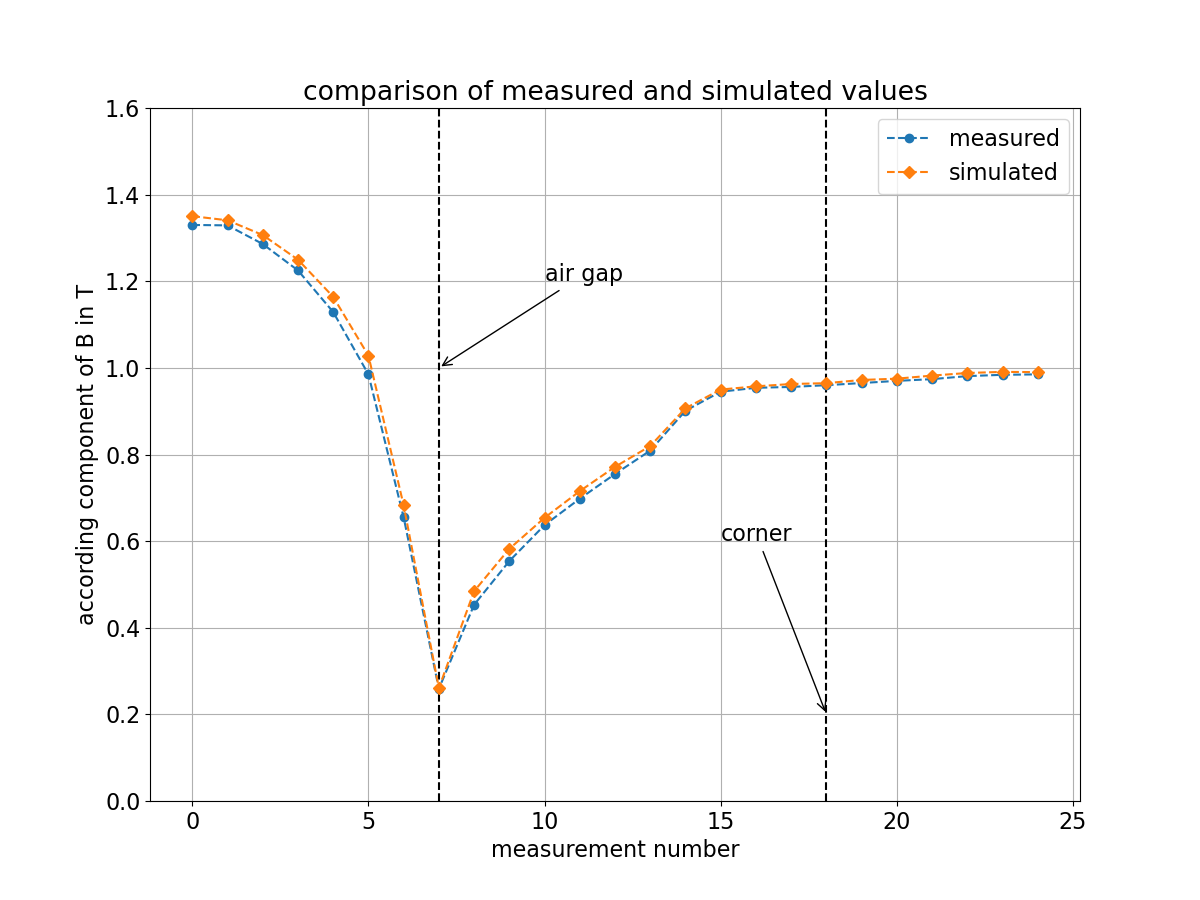

In [26]:
# plot magnetic flux density over position 
plt.figure(1, figsize=[12,9])
plt.clf()
xi = range(0, 25)
plt.plot([7, 7], [0, 1.6], "--k")
plt.plot([18, 18], [0, 1.6], "--k")
plt.plot(xi, B_msm[0:25], '--o', label="measured")
plt.plot(xi, B_sim[0:25], '--D', label="simulated")
plt.title("comparison of measured and simulated values")
plt.ylabel("according component of B in T")
plt.xlabel("measurement number")
plt.ylim(0, 1.6)
plt.grid()

plt.annotate("air gap",xy=(7, 1), arrowprops=dict(arrowstyle='->'), xytext=(10, 1.2))
plt.annotate("corner",xy=(18, 0.2), arrowprops=dict(arrowstyle='->'), xytext=(15, 0.6))

plt.legend(loc=0)
font = {'size'   : 16}
matplotlib.rc('font', **font)
plt.show(block=False)

# Related Work
1. Nakata, T., Takahashi, N., Fujiwara, K., Imai, T. and Muramatsu, K. (1991). Comparison of various methods of analysis and finite elements in 3-D magnetic field analysis. IEEE Transactions on Magnetics, 27(5), pp.4073-4076. [.pdf](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=104996)
1. Preis, K., Bardi, I., Biro, O., Magele, C., Renhart, W., Richter, K. and Vrisk, G. (1991). Numerical analysis of 3D magnetostatic fields. IEEE Transactions on Magnetics, 27(5), pp.3798-3803. [.pdf](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=123863)
1. Bandelier, Bernard & Daveau, C & Laminie, Jacques & M. Mefire, S & Rioux-Damidau, Francoise. (1999). Three-Dimensional Magnetostatic Problem. International Journal for Numerical Methods in Engineering. 46. 117-130. [.pdf](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.595.7033&rep=rep1&type=pdf)
2. Fetzer, Joachim & Kurz, Stefan & Lehner, Günther. (1996). Comparison between different formulations for the solution of 3D nonlinear magnetostatic problems using BEM-FEM coupling. Magnetics, IEEE Transactions on. 32. 663 - 666. 10.1109/20.497325. [.pdf](https://ieeexplore.ieee.org/ielx5/20/10597/00497325.pdf?tp=&arnumber=497325&isnumber=10597) 
3. Kettunen, Lauri & Forsman, Kimmo & Levine, David. (1994). Solutions of TEAM Problems 13 and 20 Using a Volume Integral Formulation. [.pdf](https://www.researchgate.net/profile/Lauri_Kettunen/publication/2756884_Solutions_of_TEAM_Problems_13_and_20_Using_a_Volume_Integral_Formulation/links/09e4150c73dd3c8a38000000/Solutions-of-TEAM-Problems-13-and-20-Using-a-Volume-Integral-Formulation.pdf)

Valentin Hanser, TU Wien, Dec 2018, valentin . hanser @ student . tuwien . ac . at